# GLMM 負の二項分布回帰

ポアソン分布が過分散のときに使用できる分布が負の二項分布であり，ポアソン回帰が過剰に精密に推定してしまうことを防ぐために使用される．

In [163]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpboost as gpb
from patsy import dmatrix

sys.path.append(os.path.abspath('../../../../../data_cleaning'))

from log_standardize import log_standardize

In [164]:
filepath = '../../../../../../data/processed/df_filtered_5years.xlsx'
df = pd.read_excel(filepath)
df = df.dropna()
df.head()

,island,year,island_id,region_code,region_name,prefecture_code,population,dummy_island_has_bridge,dummy_island_is_connected_mainland,year_bridge_opened,dummy_after_bridge_opened,year_connect_mainland,dummy_after_connect_mainland,income,prefecture_name,area_km2,distance_m
5,島後,2005,62,32528,隠岐の島町,32,17259.0,0.0,0.0,0.0,0.0,0.0,0.0,2030.888121,島根県,241.53,67840.0
6,島後,2010,62,32528,隠岐の島町,32,15930.0,0.0,0.0,0.0,0.0,0.0,0.0,1725.990958,島根県,241.53,67840.0
7,島後,2015,62,32528,隠岐の島町,32,14901.0,0.0,0.0,0.0,0.0,0.0,0.0,1613.531700,島根県,241.53,67840.0
8,島後,2020,62,32528,隠岐の島町,32,13882.0,0.0,0.0,0.0,0.0,0.0,0.0,1686.173400,島根県,241.53,67840.0
10,中ノ島,1985,63,32525,海士町,32,3339.0,0.0,0.0,0.0,0.0,0.0,0.0,363.212405,島根県,32.29,49730.0


## Define the variables

In [167]:
pop_density = df['population'] / df['area_km2']

log_std_income = log_standardize(df['income'])
log_std_area = log_standardize(df['area_km2'])
log_std_dist = log_standardize(df['distance_m'])
log_std_density = log_standardize(pop_density)

islands = pd.Categorical(df['island_id'])
islands_codes = islands.codes
n_islands = len(islands.categories)

# 過分散パラメータ
mean_population = np.mean(df['population'])
var_population = np.var(df['population'])

alpha = (var_population - mean_population) / mean_population**2
shape = 1 / alpha

## モデリング

### GLMM

$$
Population = \lambda \\

\log\lambda = \beta_0 + \beta_1 Bridge + X^T \gamma + Island + Year \\
$$

- ランダム効果: 島

In [188]:
group = df['island_id']
y = df['population']
X = dmatrix('bridge + log_income + log_area + log_distance + pop_density + C(year)', data=df, return_type='dataframe')

model = gpb.GPModel(group_data=group, likelihood='negative_binomial') # 負の二項分布
model.fit(y=y, X=X, params={'std_dev': True})

pred = model.predict(X_pred=X, group_data_pred=group)['mu']
residuals = y - pred

print(model.summary())

Model summary:
 Log-lik      AIC      BIC
 -5020.6 10069.21 10136.46
Nb. observations: 901
Nb. groups: 152 (island_id)
-----------------------------------------------------
Covariance parameters (random effects):
           Param.
island_id  1.1378
-----------------------------------------------------
Linear regression coefficients (fixed effects):
                 Param.  Std. dev.  z value  P(>|z|)
Intercept        6.0324     0.4282  14.0880   0.0000
C(year)[T.1990] -0.0934     0.0620  -1.5070   0.1318
C(year)[T.1995] -0.0781     0.0506  -1.5416   0.1232
C(year)[T.2000] -0.2101     0.0508  -4.1327   0.0000
C(year)[T.2005] -0.2711     0.0513  -5.2813   0.0000
C(year)[T.2010] -0.3981     0.0517  -7.7006   0.0000
C(year)[T.2015] -0.5318     0.0519 -10.2537   0.0000
C(year)[T.2020] -0.6855     0.0522 -13.1232   0.0000
bridge           0.1131     0.0361   3.1344   0.0017
log_income      -0.0092     0.0056  -1.6380   0.1014
log_area         1.0058     0.0538  18.6830   0.0000
log_distance 

In [200]:
np.random.seed(42)

group = df['island_id']
y = df['population']
X = dmatrix('bridge + log_std_income + log_std_area + log_std_dist + log_std_density + C(year)', data=df, return_type='dataframe')

model = gpb.GPModel(group_data=group, likelihood='negative_binomial') # 負の二項分布
model.fit(y=y, X=X, params={'std_dev': True})

pred = model.predict(X_pred=X, group_data_pred=group)['mu']
residuals = y - pred

print(model.summary())

Model summary:
 Log-lik     AIC     BIC
-3845.05 7718.11 7785.36
Nb. observations: 901
Nb. groups: 152 (island_id)
-----------------------------------------------------
Covariance parameters (random effects):
           Param.
island_id   0.144
-----------------------------------------------------
Linear regression coefficients (fixed effects):
                 Param.  Std. dev.   z value  P(>|z|)
Intercept        5.5495     0.0318  174.6902   0.0000
C(year)[T.1990] -0.0002     0.0062   -0.0362   0.9711
C(year)[T.1995] -0.0009     0.0024   -0.3582   0.7202
C(year)[T.2000] -0.0009     0.0015   -0.6163   0.5377
C(year)[T.2005] -0.0011     0.0021   -0.5245   0.5999
C(year)[T.2010] -0.0014     0.0032   -0.4230   0.6723
C(year)[T.2015] -0.0016     0.0038   -0.4211   0.6737
C(year)[T.2020] -0.0019     0.0046   -0.4225   0.6727
bridge           0.0005     0.0072    0.0765   0.9390
log_std_income   0.0000     0.0002    0.1342   0.8932
log_std_area     1.5256     0.0179   85.3601   0.0000
log_s

In [151]:
group = df['island_id']
y = df['population']
X = dmatrix('bridge + log_income + log_area + log_distance + density', data=df, return_type='dataframe')

model = gpb.GPModel(group_data=group, likelihood='negative_binomial') # 負の二項分布
model.fit(y=y, X=X, params={'std_dev': True})

pred = model.predict(X_pred=X, group_data_pred=group)['mu']
residuals = y - pred

print(model.summary())

Model summary:
 Log-lik     AIC      BIC
 -5355.0 10724.0 10757.63
Nb. observations: 901
Nb. groups: 152 (island_id)
-----------------------------------------------------
Covariance parameters (random effects):
           Param.
island_id  0.7707
-----------------------------------------------------
Linear regression coefficients (fixed effects):
              Param.  Std. dev.  z value  P(>|z|)
Intercept     4.9838     0.3695  13.4896   0.0000
bridge        0.0840     0.0616   1.3633   0.1728
log_income   -0.0611     0.0086  -7.1066   0.0000
log_area      1.0182     0.0449  22.6991   0.0000
log_distance -0.0318     0.0488  -0.6516   0.5146
density       0.0021     0.0001  22.3319   0.0000
-----------------------------------------------------
Additional parameters:
        Param.
shape  23.0059


- ランダム効果: 島
- 固定効果: 年

In [153]:
y = df['population']
group = df['island_id']
X = dmatrix('bridge + log_income + log_area + log_distance + density+ C(year)', data=df, return_type='dataframe')

gp_model = gpb.GPModel(group_data=group, likelihood='negative_binomial')
gp_model.fit(y=y, X=X, params={'std_dev': True})
gp_model.summary()

Model summary:
 Log-lik     AIC      BIC
-5020.55 10069.1 10136.35
Nb. observations: 901
Nb. groups: 152 (island_id)
-----------------------------------------------------
Covariance parameters (random effects):
           Param.
island_id  1.1322
-----------------------------------------------------
Linear regression coefficients (fixed effects):
                 Param.  Std. dev.  z value  P(>|z|)
Intercept        5.9990     0.4261  14.0784   0.0000
C(year)[T.1990] -0.0753     0.0618  -1.2186   0.2230
C(year)[T.1995] -0.0666     0.0503  -1.3223   0.1861
C(year)[T.2000] -0.1997     0.0505  -3.9524   0.0001
C(year)[T.2005] -0.2627     0.0510  -5.1486   0.0000
C(year)[T.2010] -0.3897     0.0514  -7.5815   0.0000
C(year)[T.2015] -0.5222     0.0516 -10.1270   0.0000
C(year)[T.2020] -0.6762     0.0519 -13.0192   0.0000
bridge           0.1175     0.0360   3.2652   0.0011
log_income      -0.0096     0.0056  -1.7080   0.0876
log_area         1.0100     0.0537  18.8019   0.0000
log_distance   

In [120]:
y = df['population']
group = df['island_id']
bridge = df['dummy_after_bridge_opened']
X = dmatrix('bridge + log_income + log_area + log_distance + C(year)', data=df, return_type='dataframe')

gp_model = gpb.GPModel(group_data=group, ind_effect_group_rand_coef=bridge, likelihood='negative_binomial')
gp_model.fit(y=y, X=X, params={'std_dev': True})
gp_model.summary()

Model summary:
 Log-lik      AIC     BIC
-5060.93 10147.86 10210.3
Nb. observations: 901
Nb. groups: 152 (island_id)
-----------------------------------------------------
Covariance parameters (random effects):
           Param.
island_id  1.4222
-----------------------------------------------------
Linear regression coefficients (fixed effects):
                 Param.  Std. dev.  z value  P(>|z|)
Intercept        6.5368     0.5423  12.0542   0.0000
C(year)[T.1990] -0.0833     0.0626  -1.3302   0.1835
C(year)[T.1995] -0.0622     0.0046 -13.5459   0.0000
C(year)[T.2000] -0.2165     0.0153 -14.1047   0.0000
C(year)[T.2005] -0.2949     0.0164 -18.0113   0.0000
C(year)[T.2010] -0.4440     0.0167 -26.5707   0.0000
C(year)[T.2015] -0.5958     0.0166 -35.9168   0.0000
C(year)[T.2020] -0.7686     0.0168 -45.8082   0.0000
bridge           0.0880     0.0373   2.3600   0.0183
log_income      -0.0057     0.0058  -0.9691   0.3325
log_area         1.0088     0.0809  12.4767   0.0000
log_distance   

In [96]:
bridge_effects_est = gp_model.get_coef()
bridge_effects_est

,Intercept,C(year)[T.1990],C(year)[T.1995],C(year)[T.2000],C(year)[T.2005],C(year)[T.2010],C(year)[T.2015],C(year)[T.2020],bridge,log_income,log_area,log_distance
Param.,6.568542,-0.085777,-0.065724,-0.220044,-0.298711,-0.447845,-0.599789,-0.772547,0.085880,-0.005432,1.001411,-0.196632
Std. dev.,0.466490,0.064974,0.052954,0.053144,0.053586,0.053774,0.053682,0.053729,0.037586,0.005820,0.059557,0.063144


## 残差分析

In [98]:
pred = gp_model.predict(X_pred=X, group_data_pred=group)['mu']
resid = y - pred

### 残差プロット

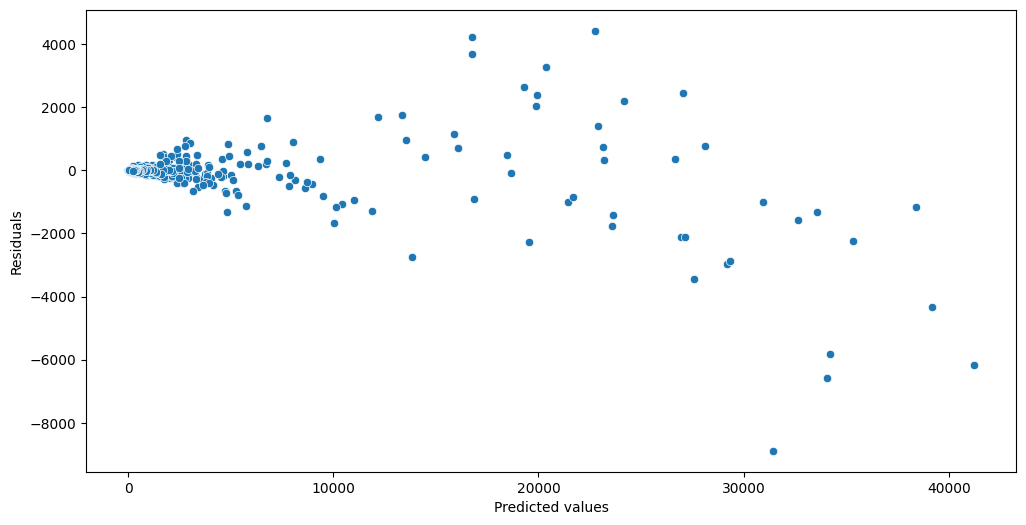

In [99]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=pred, y=resid)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

### 残差ヒストグラム

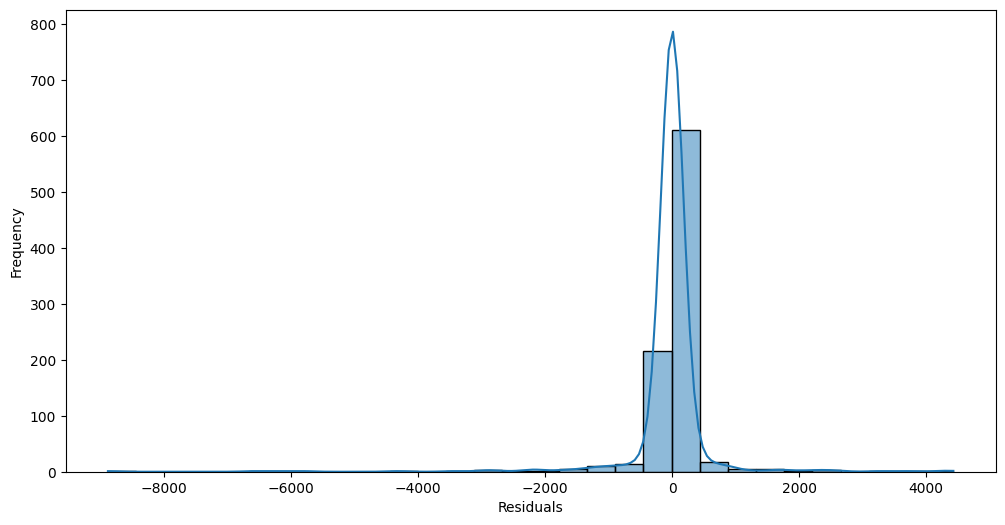

In [100]:
plt.figure(figsize=(12, 6))
sns.histplot(resid, bins=30, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()